# EECE5644 HW1P1 Ethan Holand

5/25/2022

Import relevant information:

In [167]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

import matplotlib.pyplot as plt # For general plotting
import numpy as np
from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

Enter given information:

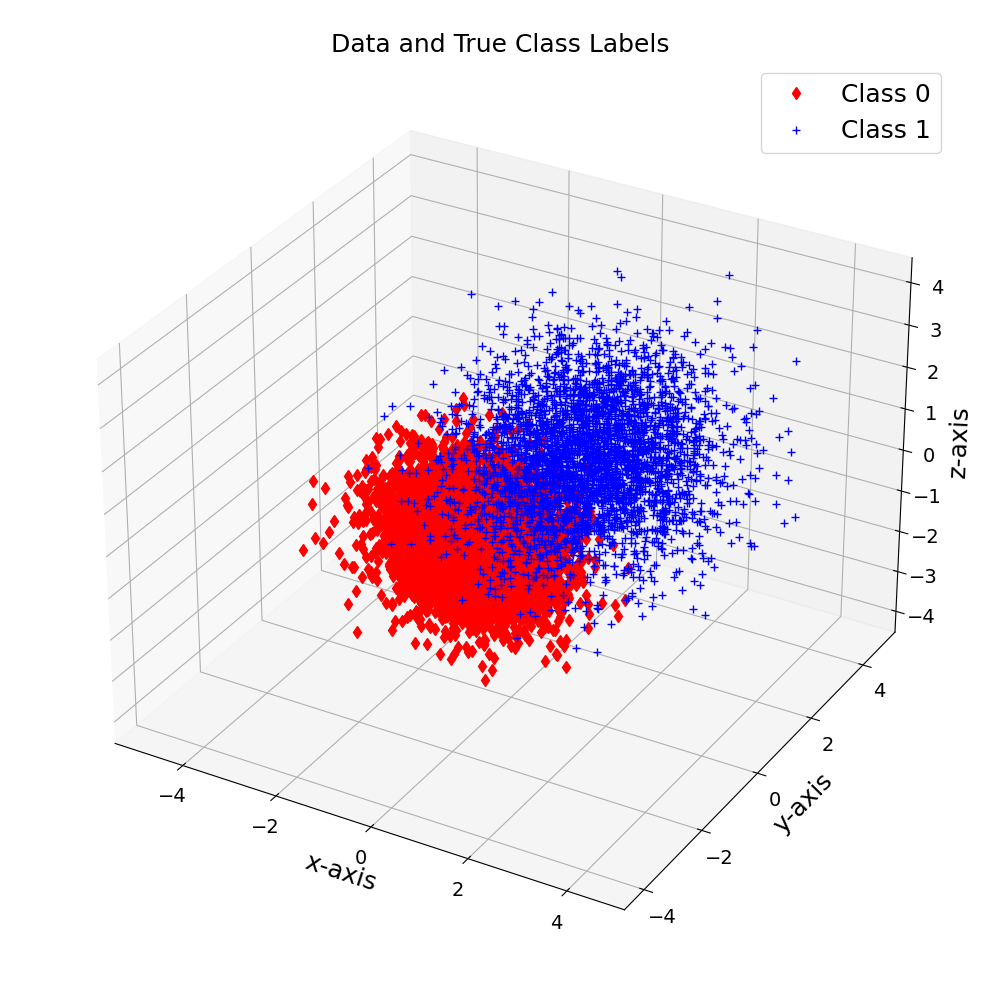

In [168]:
N = 10000
# Mean and covariance of data pdfs conditioned on labels
mu = np.array([[-0.5, -0.5, -0.5],
               [1, 1, 1]]) # Gaussian distributions means
Sigma = np.array([[[1, -0.5, 0.3], 
                   [-0.5, 1, -0.5], 
                   [0.3, -0.5, 1]],
                  [[1, 0.3, -0.2],
                   [0.3, 1, 0.3],
                   [-0.2, 0.3, 1]]]) # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1] # 1d, 2d, or 3d

# Class priors
priors = np.array([0.65, 0.35])  
C = len(priors) # Number of classes
# Decide randomly which samples will come from each component (taking class 1 from standard normal values above 0.35)
labels = np.random.rand(N) >= priors[0]
L = np.array(range(C)) # Array of class labels
Nl = np.array([sum(labels == l) for l in L]) # Find number of each label

# Draw samples from each class pdf
X = np.zeros((N, n)) # Empty coordinate matrix for each sample
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0]) # Draw position based on mean and variance for all samples from class 0
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1]) # Draw position based on mean and variance for all samples from class 1

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
plt.plot(X[labels==0, 0], X[labels==0, 1], X[labels==0, 2], 'rd', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], X[labels==1, 2], 'b+', label="Class 1")


plt.legend()
ax.set_xlabel(r"x-axis")
ax.set_ylabel(r"y-axis")
ax.set_zlabel(r"z-axis")
plt.title("Data and True Class Labels")
plt.tight_layout()
plt.show()

## Part A: ERM classification using the knowledge of true data pdf
1. Specify the minimum expected risk classification rule in the form of a likelihood-ratio test: $ \frac{p(\mathbf{x}|L=1)}{p(\mathbf{x}|L=0)} >? \gamma $ where the threshold γ is a function of class priors and fixed (non-negative) lossvalues for each of the four cases $ D = i|L = j $ where D is the decision label that is either 0 or 1, like L.


In [169]:
# MAP classifier (is a special case of ERM corresponding to 0-1 loss)
# 0-1 loss values yield MAP decision rule
Lambda = np.ones((C, C)) - np.identity(C)
print(Lambda)

[[0. 1.]
 [1. 0.]]


In [170]:
# Expected Risk Minimization Classifier (using true model parameters)
# In practice the parameters would be estimated from training samples
# Using log-likelihood-ratio as the discriminant score for ERM
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L]) # CxN array, gives probability of a given data point given a specific class
print(class_conditional_likelihoods)
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0]) # log difference of likelihood of being in class 1 vs class 0

# Gamma threshold for MAP decision rule (remove Lambdas and you obtain same gamma on priors only; 0-1 loss simplification)
gamma_map = (Lambda[1,0] - Lambda[0,0]) / (Lambda[0,1] - Lambda[1,1]) * priors[0]/priors[1]
# Same as:
# gamma_map = priors[0]/priors[1] for 0-1 loss
print(gamma_map)

[[0.05552713 0.00517651 0.05238589 ... 0.00001183 0.0605304  0.00714262]
 [0.000542   0.03845083 0.00220643 ... 0.02628097 0.00348204 0.00029834]]
1.8571428571428574


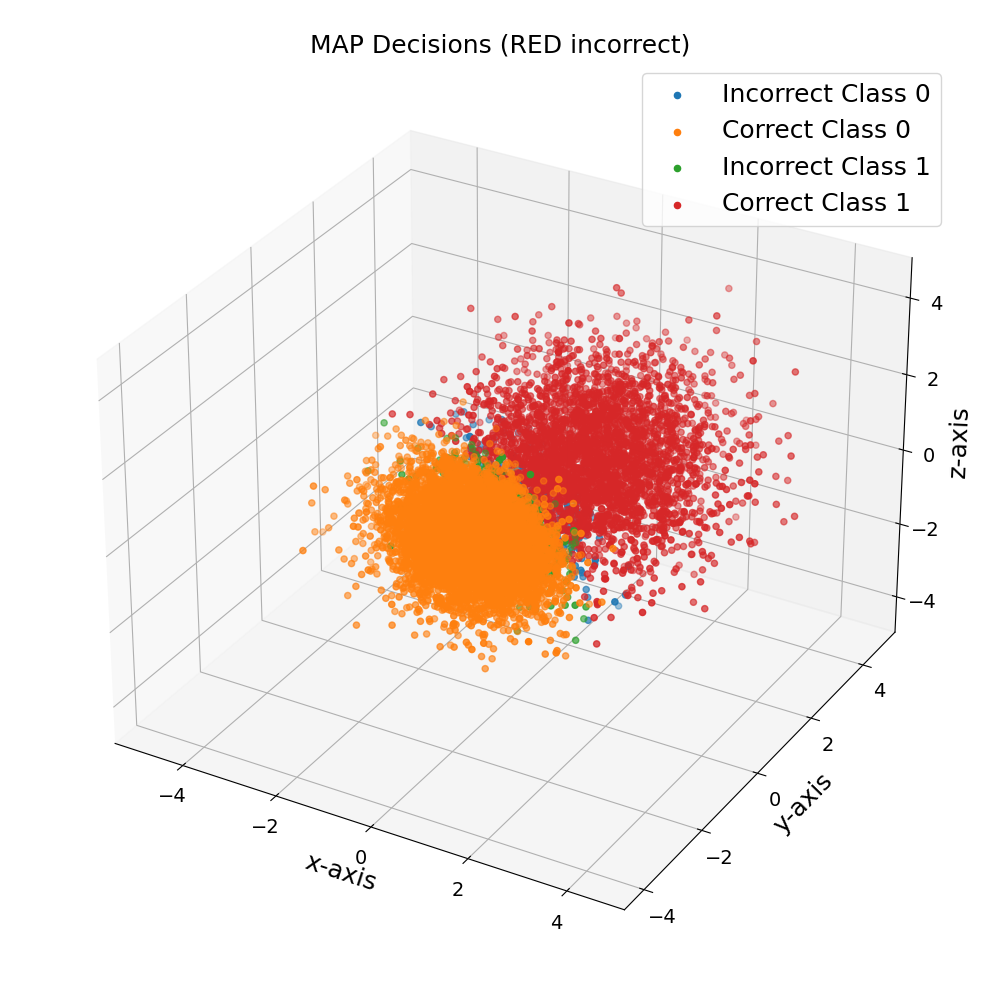

In [171]:
decisions_map = discriminant_score_erm >= np.log(gamma_map) # Assign "true" wherever the discriminant score is above the threshold

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative
ind_00_map = np.argwhere((decisions_map==0) & (labels==0)) # Indices
p_00_map = len(ind_00_map) / Nl[0] # Probability

# False Positive
ind_10_map = np.argwhere((decisions_map==1) & (labels==0)) # Indices
p_10_map = len(ind_10_map) / Nl[0] # False Positive Probability

# False Negative
ind_01_map = np.argwhere((decisions_map==0) & (labels==1)) # Indices
p_01_map = len(ind_01_map) / Nl[1] # False Negative Probability

# True Positive
ind_11_map = np.argwhere((decisions_map==1) & (labels==1)) # Indices
p_11_map = len(ind_11_map) / Nl[1] # True Positive Probability

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)

# Display MAP decisions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# class 0 circle, class 1 +, correct green, incorrect red
ax.scatter(X[ind_10_map, 0], X[ind_10_map, 1], X[ind_10_map, 2], 'or', label="Incorrect Class 0")
ax.scatter(X[ind_00_map, 0], X[ind_00_map, 1], X[ind_00_map, 2], 'og', label="Correct Class 0")
ax.scatter(X[ind_01_map, 0], X[ind_01_map, 1], X[ind_01_map, 2], '+r', label="Incorrect Class 1")
ax.scatter(X[ind_11_map, 0], X[ind_11_map, 1], X[ind_11_map, 2], '+g', label="Correct Class 1")

plt.legend()
ax.set_xlabel(r"x-axis")
ax.set_ylabel(r"y-axis")
ax.set_zlabel(r"z-axis")
plt.title("MAP Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

In [172]:
from sys import float_info # Threshold smallest positive floating value

# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1))) # Number of assigned labels for each class

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    # (tau values are the same as gamma thresholds)
    taus = ([sorted_score[0] - float_info.epsilon] + 
             sorted_score +
             [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= t for t in taus]

    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]

    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    return roc, taus

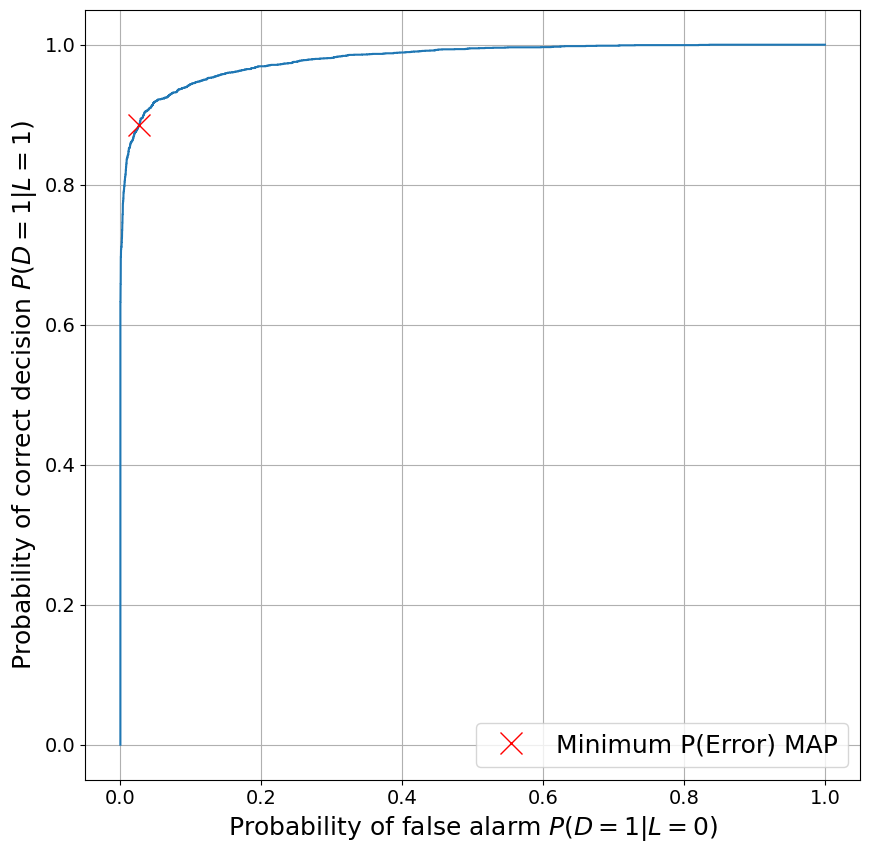

In [173]:
# Construct the ROC for ERM by changing log(gamma)
roc_erm, _ = estimate_roc(discriminant_score_erm, labels) # p(false postive), p(true positive) for each threshold from min value to max
roc_map = np.array((p_10_map, p_11_map)) # p(false postive), p(true positive) given optimal threshold

plt.ioff() # These are Jupyter only lines to avoid showing the figure when I don't want
fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
plt.ion() # Re-activate "interactive" mode

ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Minimum P(Error) MAP", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.grid(True)
display(fig_roc) # Display as .png

fig_roc;

## Naive Bayes

In [174]:
def perform_nb(X, labels, C=2, plot_vec=True):
    """  Naive Bayes Classification on data from two classes (C=2).

    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        labels: Class labels per sample received as an [N, 1] column.
        C: Number classes, explicitly clarifying that we're doing binary classification here.
        plot_vec: If you want the option of directly plotting the linear projection vector over your input space.

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """

    nb = GaussianNB()
    X_fit = nb.fit(X, labels)  # Is a fitted estimator, not actual data to project
    z = nb.flatten()
    w = X_fit.coef_[0]

    return w, z

In [175]:
# # Naive Bayes Classifer (using true model parameters)
# _, discriminant_score_nb = perform_nb(X, labels)

# # Estimate the ROC curve for this NB classifier
# roc_nb, tau_nb = estimate_roc(discriminant_score_nb, labels)

# # ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# prob_error_nb = np.array((roc_nb[0,:], 1 - roc_nb[1,:])).T.dot(Nl.T / N)

# # Min prob error
# min_prob_error_nb = np.min(prob_error_nb)
# min_ind = np.argmin(prob_error_nb)

# # Display the estimated ROC curve fornb nb and indicate the operating points
# # with smallest empirical error probability estimates (could be multiple)
# ax_roc.plot(roc_nb[0], roc_nb[1], 'b:')
# ax_roc.plot(roc_nb[0, min_ind], roc_nb[1, min_ind], 'r.', label="Minimum P(Error) LDA", markersize=16)
# ax_roc.set_title("ROC Curves for ERM and LDA")
# ax_roc.legend()

# plt.show()
# fig_roc;

## Fisher LDA

In [176]:
def perform_lda(X, labels):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    Note: you can generalize this implementation to multiple classes by finding a
    projection matrix W (rather than vector) that reduces dimensionality n inputs
    to a multidimensional projection z=W'*x (e.g. z of dimension C-1). Now we have
    a crude but quick way of achieving class-separability-preserving linear dimensionality
    reduction using the Fisher LDA objective as a measure of class separability.

    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        labels: Class labels per sample received as an [N, 1] column.
        
    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """

    lda = LinearDiscriminantAnalysis()
    X_fit = lda.fit(X, labels)  # Is a fitted estimator, not actual data to project
    z = lda.transform(X).flatten()
    w = X_fit.coef_[0]

    return w, z

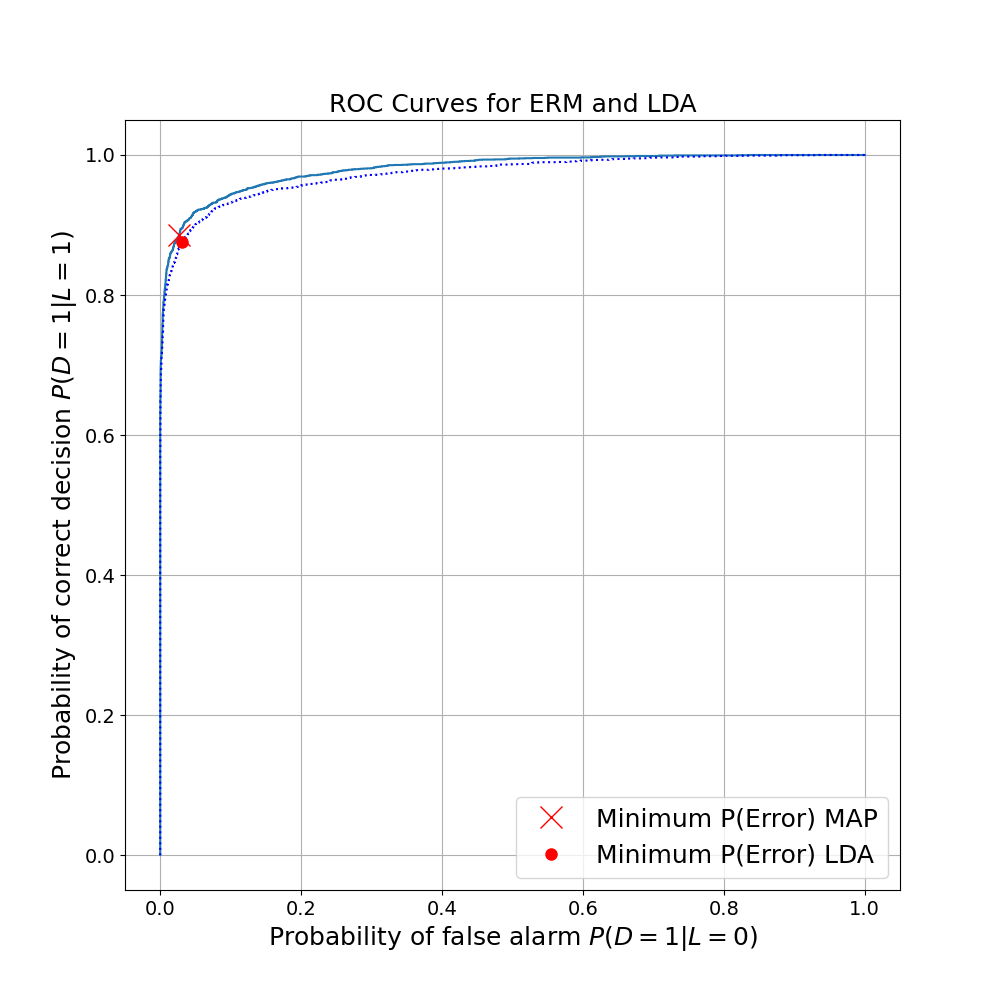

In [177]:
# Fisher LDA Classifer (using true model parameters)
_, discriminant_score_lda = perform_lda(X, labels)

# Estimate the ROC curve for this LDA classifier
roc_lda, tau_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda[0,:], 1 - roc_lda[1,:])).T.dot(Nl.T / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda[0], roc_lda[1], 'b:')
ax_roc.plot(roc_lda[0, min_ind], roc_lda[1, min_ind], 'r.', label="Minimum P(Error) LDA", markersize=16)
ax_roc.set_title("ROC Curves for ERM and LDA")
ax_roc.legend()

plt.show()
fig_roc;

# Old Code

Smallest P(error) for ERM = 0.057499999999999996


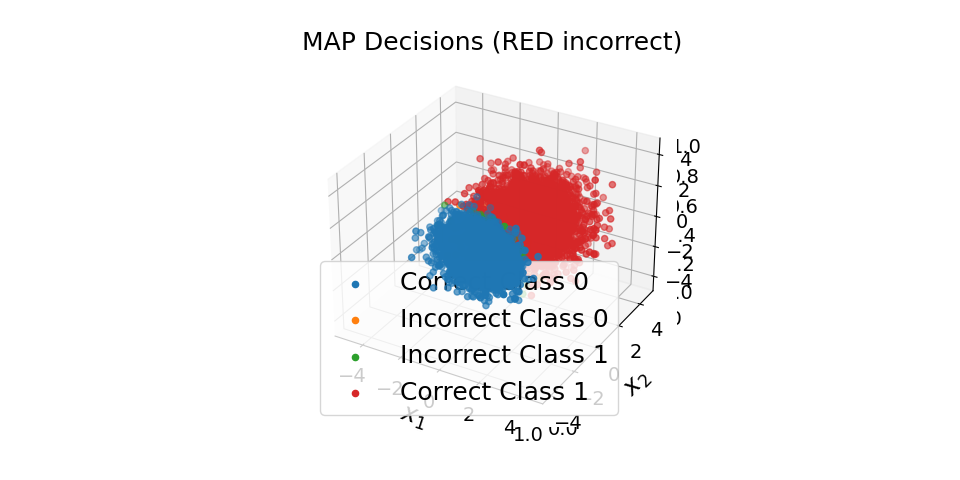

In [178]:
# Expected Risk Minimization Classifier (using true model parameters)
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L])
# Discriminant score is LHS of likelihood-ratio test (LRT) 
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Gamma threshold for MAP decision rule (same gamma on priors only; 0-1 loss simplification)
gamma_map = priors[0]/priors[1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

Nl = np.array([sum(labels == l) for l in L])

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)

# Display MAP decisions
# fig_disc_grid, ax_disc = plt.subplots(figsize=(10,10), projection='3d');

fig = plt.figure(figsize=plt.figaspect(0.5))
fig_disc_grid = fig.add_subplot(111, projection='3d')
ax_disc = fig.add_subplot(111, projection='3d')

# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.scatter(X[ind_00_map, 0], X[ind_00_map, 1], X[ind_00_map, 2], 'g', label="Correct Class 0")
ax_disc.scatter(X[ind_10_map, 0], X[ind_10_map, 1], X[ind_10_map, 2], 'r', label="Incorrect Class 0")
ax_disc.scatter(X[ind_01_map, 0], X[ind_01_map, 1], X[ind_01_map, 2], 'r', label="Incorrect Class 1")
ax_disc.scatter(X[ind_11_map, 0], X[ind_11_map, 1], X[ind_11_map, 2], 'g', label="Correct Class 1")

ax_disc.legend()
ax_disc.set_xlabel(r"$x_1$")
ax_disc.set_ylabel(r"$x_2$")
ax_disc.set_title("MAP Decisions (RED incorrect)")

print("Smallest P(error) for ERM = {}".format(prob_error_erm))
fig_disc_grid;

In [179]:
gamma_map = priors[0]/priors[1]

print(gamma_map)

# Generate a grid of scores that spans the full range of data 
x_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
y_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)
z_grid = np.linspace(np.floor(np.min(X[:,2])), np.ceil(np.max(X[:,2])), 100)
[h, v, d] = np.meshgrid(x_grid, y_grid, z_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxyz = np.array([h.reshape(-1), v.reshape(-1), d.reshape(-1)])
likelihood_grid_vals = np.array([multivariate_normal.pdf(gridxyz.T, mu[l], Sigma[l]) for l in L-1])
# Where a score of 0 indicates decision boundary level
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)
print(discriminant_score_grid_vals)

1.8571428571428574
[-21.10349918 -20.93608106 -20.7698482  ... -78.86633728 -79.45005141
 -80.03495079]
